<a href="https://colab.research.google.com/github/lilyzhizhou/ML-Final-Project/blob/main/Final_assn_Neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Necessary Libraries

In [54]:
# importing PyTorch library as 't' for convenience
import torch as t

# importing other necessary libraries
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#!pip install category_encoders
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


Load data

In [ ]:
# Read CSV file into Pandas df
import pandas as pd

df = pd.read_csv('datapd.csv')
df.head()

,Unnamed: 0,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex,Patient_ID
0,2,1,63,30.9,NaN,0,1,0,1,0,1,1,1001000000000054
1,2386,1,66,23.6,3.54,1,1,1,0,0,1,1,1001000000004538
2,7781,0,68,34.3,5.55,1,1,1,0,0,1,0,1001000000007331
3,7644,1,73,28.5,3.78,1,1,0,1,1,1,0,1001000000007333
4,2290,0,53,33.4,5.38,0,1,1,0,1,1,0,1001000000009032


Checking Data Types

In [30]:
# checking the data types
df.dtypes

Unnamed: 0             int64
predm                  int64
Age_at_Exam            int64
BMI                  float64
Total_Cholesterol    float64
Depression             int64
HTN                    int64
OA                     int64
COPD                   int64
corstrd_bin            int64
htnmed_bin             int64
Sex                    int64
dtype: object

Check Missing values

In [ ]:
print(df.isna().sum())

Unnamed: 0             0
predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
Patient_ID             0
dtype: int64


Impute by median

In [ ]:
#impute missing data in the cholesterol column with median
df['Total_Cholesterol']=df['Total_Cholesterol'].fillna(df['Total_Cholesterol'].median())

df.info()

# Print the cleaned DataFrame
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6414 entries, 0 to 6413
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6414 non-null   int64  
 1   predm              6414 non-null   int64  
 2   Age_at_Exam        6414 non-null   int64  
 3   BMI                6414 non-null   float64
 4   Total_Cholesterol  6414 non-null   float64
 5   Depression         6414 non-null   int64  
 6   HTN                6414 non-null   int64  
 7   OA                 6414 non-null   int64  
 8   COPD               6414 non-null   int64  
 9   corstrd_bin        6414 non-null   int64  
 10  htnmed_bin         6414 non-null   int64  
 11  Sex                6414 non-null   int64  
 12  Patient_ID         6414 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 651.5 KB
      Unnamed: 0  predm  Age_at_Exam   BMI  Total_Cholesterol  Depression  \
0              2      1           63  30.9 

In [ ]:
#double check if there are not missing values anymore
print(df.isna().sum())

Unnamed: 0           0
predm                0
Age_at_Exam          0
BMI                  0
Total_Cholesterol    0
Depression           0
HTN                  0
OA                   0
COPD                 0
corstrd_bin          0
htnmed_bin           0
Sex                  0
Patient_ID           0
dtype: int64


In [ ]:
#remove "Patient_ID" column
df=df.drop('Patient_ID', axis=1)

In [ ]:
print(df.isna().sum())


Unnamed: 0           0
predm                0
Age_at_Exam          0
BMI                  0
Total_Cholesterol    0
Depression           0
HTN                  0
OA                   0
COPD                 0
corstrd_bin          0
htnmed_bin           0
Sex                  0
dtype: int64


Define numerical and categorical columns

In [ ]:
# create list of numerical, categorical, multinomial features
target_column = 'predm'
categorical_columns = ['Depression', 'HTN',
                       'OA', 'COPD', 'Sex',
                       'corstrd_bin','htnmed_bin']
#multinomial_columns = [] there are none
numerical_columns = ['Age_at_Exam','BMI','Total_Cholesterol']

Convert numeric categorical categories into descriptive categories

In [ ]:
# Convert numeric categorical variables into descriptive categories
df_descr = df.copy()

df_descr['predm'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['Depression'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['HTN'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['OA'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['COPD'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['corstrd_bin'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['htnmed_bin'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)

df_descr.head()

,Unnamed: 0,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,2,Yes,63,30.9,4.69,No,Yes,No,Yes,No,Yes,1
1,2386,Yes,66,23.6,3.54,Yes,Yes,Yes,No,No,Yes,1
2,7781,No,68,34.3,5.55,Yes,Yes,Yes,No,No,Yes,0
3,7644,Yes,73,28.5,3.78,Yes,Yes,No,Yes,Yes,Yes,0
4,2290,No,53,33.4,5.38,No,Yes,Yes,No,Yes,Yes,0


Check distribution of outcome variable

In [ ]:
# Checking for Pre-Diabetes imbalance

# Compute the count of each class in the 'target' column
counts = df_descr['predm'].value_counts()

# Define colors for the pie chart sections
colors = ['#a3416c', '#ebc898']

# Construct a pie chart with plotly
# 'names' are the class labels, and 'values' are the counts for each class
fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # creates a donut-styled pie chart
    title='Distribution of predm',
    color_discrete_sequence=colors
)

# Update the layout of the pie chart for better presentation and clarity
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='target'
    ),
    title=dict(
        text='Distribution of Classes in predm',
        x=0.45,
        xanchor='center',
        y=0.95,
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

# Display the pie chart
fig.show()

Check Distributions of variables

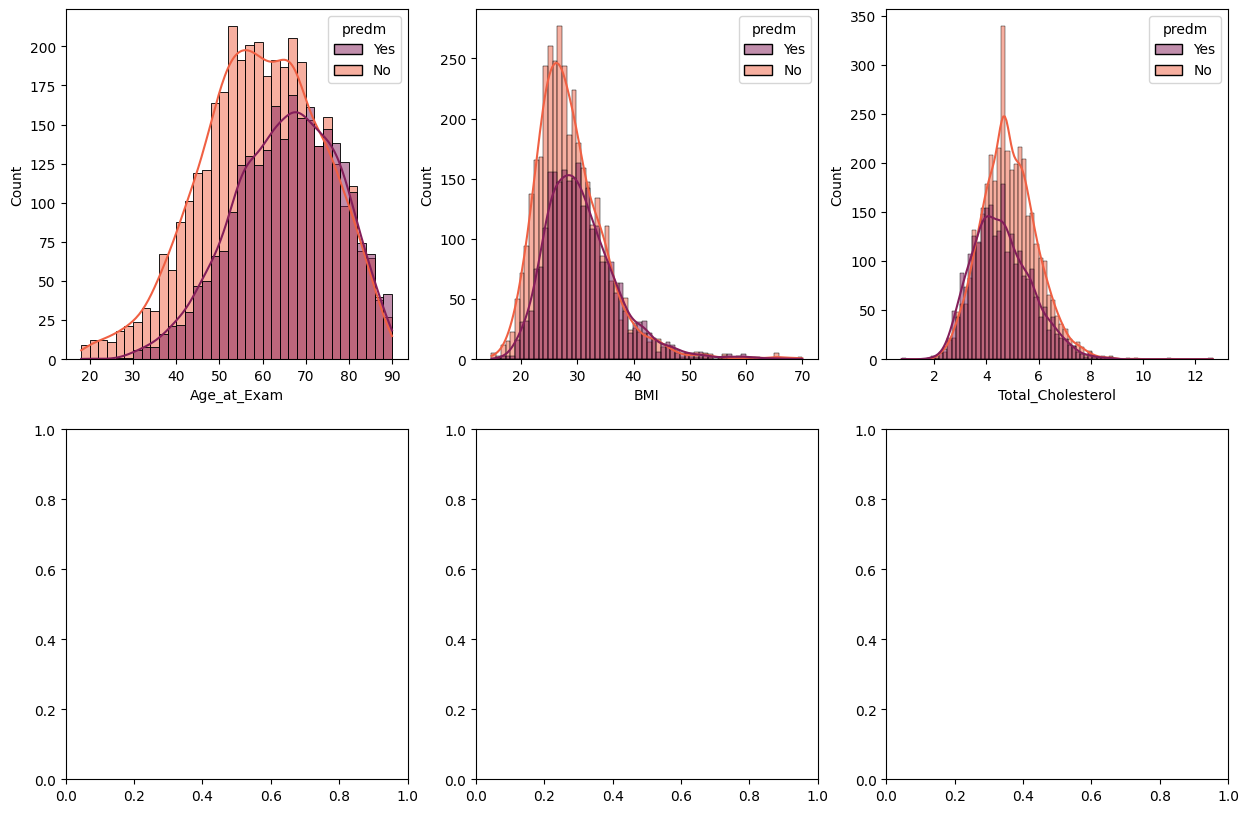

In [ ]:
# checking the difference in distribution of numerical features in two classes

# Create a grid of subplots with 1 rows and 3 columns
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

# Loop over each feature in numerical and multinomial lists
for i, column in enumerate(numerical_columns):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // 3
    y = i % 3

    # Plot a histogram of the feature split by the 'target' class
    # kde=True adds a Kernel Density Estimate plot to smooth the histogram, providing a clearer view of the data distribution
    sns.histplot(df_descr, x=column, hue= target_column, kde=True, palette='rocket', ax=axs[x][y])

# Display all the subplots
plt.show()


Proportion of positive cases

In [ ]:
df['predm'].mean()

0.4078578110383536

Data Preparation

In [ ]:
# Randomly sample 70% of the data for training
train_data = df.sample(frac = .7, random_state=10)

# Use the remaining 30% for testing
test_data = df.drop(train_data.index)

# Data Preparation

# Extract the 'predm' column as the target variable for training and testing
Y_train = train_data['predm'].to_numpy()
Y_test = test_data['predm'].to_numpy()

# Extract the features (excluding 'predm') for training and testing
X_train = train_data.drop('predm', axis=1).to_numpy()
X_test = test_data.drop('predm', axis=1).to_numpy()

# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Initializing Neural Network Parameters in PyTorch

In [ ]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((11, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

Implementing the Forward Pass of a Neural Network in PyTorch

In [ ]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

Preparing Data and Training Utilities for Neural Network Training in PyTorch

In [42]:
#Explicitly convert the data types of your NumPy array elements to a compatible numeric type
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(Y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 15

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

Training Loop for a Neural Network in PyTorch

In [43]:
train_loss_list = [] #initializes an empty list to store the average loss of each epoch

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 50 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X) #calls the forward function to compute predictions based on the batch of input data x

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Visualizing Training Loss over Epochs with Maptlotlib in Python

Text(0, 0.5, 'loss')

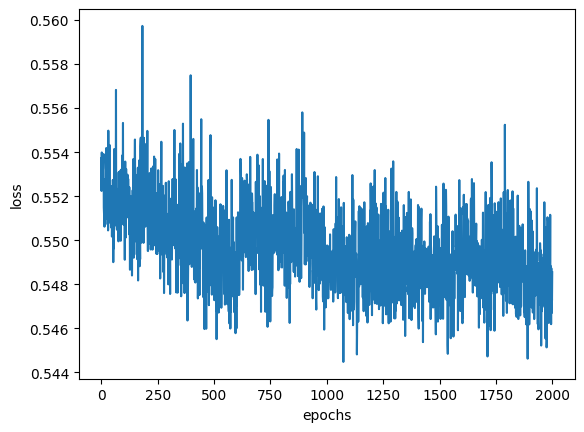

In [44]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

Evaluating Model Performance on Validation Data

In [34]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

0.5764123797416687
0.5483413338661194


Data Splitting

In [55]:
# Splitting the data into 70% training and 30% testing
train = df.sample(frac=0.7, random_state=10)
test = df.drop(train.index)

# Initializing a column transformer that will handle categorical data encoding
ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [c for c in categorical_columns if c != 'country']),
                        ('target_encoder', TargetEncoder(), ['country'])],
                       remainder='passthrough')

# Initializing a Decision Tree classifier
dt = tree.DecisionTreeClassifier(criterion='entropy',class_weight='balanced')

# Creating a pipeline that first preprocesses the data and then applies the decision tree
model = Pipeline([
    ('pre_process', ct),
    ('DT', dt)
])

# Training the model on the training data
model = model.fit(train.drop('predm', axis=1), train['predm'])

# Predicting and evaluating the model's performance on the training data
Y_pred = model.predict(train.drop('predm', axis=1))
accuracy_score(train['predm'], Y_pred)

NameError: ignored

Hyperparameter Tuning Using Grid Seach

In [48]:
# Define the hyperparameter values that should be tested
param_dist = {
    "DT__number_of_input_features" == 11
    "DT__number_of_hidden_units" == [2, 4, 5, 6, 7, 8],
    "DT__epochs" == [100, 200, 500, 1000, 2000]
    "DT__learning_rate" == [0.001, 0.005, 0.01, 0.02, 0.03, 0.05],
    "DT__batch_size" == [20, 32, 40, 50]
}

# Setting up Stratified K-Fold cross-validation
kf = KFold(n_splits=5)

# Initialize Grid Search with the model and the hyperparameters to search
random_search = GridSearchCV(
    model, param_gri d=param_dist, cv=kf
)

# Train Grid Search on the training data
random_search.fit(train.drop('predm', axis=1), train['predm'])

# Extract results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Display the set of parameters that achieved the best score
results[results['rank_test_score'] == 1]


NameError: ignored

In [50]:
from sklearn.model_selection import KFold, GridSearchCV
import pandas as pd

# Define the hyperparameter values that should be tested
param_dist = {
    "DT__number_of_input_features": [11],  # Use ':' instead of '=='
    "DT__number_of_hidden_units": [2, 4, 5, 6, 7, 8],
    "DT__epochs": [100, 200, 500, 1000, 2000],  # Add a comma
    "DT__learning_rate": [0.001, 0.005, 0.01, 0.02, 0.03, 0.05],
    "DT__batch_size": [20, 32, 40, 50]
}

# Assuming 'model' is defined somewhere before this code

# Setting up Stratified K-Fold cross-validation
kf = KFold(n_splits=5)

# Initialize Grid Search with the model and the hyperparameters to search
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=kf
)

# Assuming 'train' DataFrame is defined before this code

# Train Grid Search on the training data
random_search.fit(df.drop('predm', axis=1), df['predm'])

# Extract results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Display the set of parameters that achieved the best score
best_params = results[results['rank_test_score'] == 1]['params']
print("Best Parameters:", best_params)

TypeError: ignored

Regularized Training of a Neural Network in Pytorch

In [ ]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 11
number_of_hidden_units = 5
epochs = 200
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))


Epoch 0/200 ---> Train Accuracy: 0.6986637115478516, Validation Accuracy: 0.7042619585990906
Epoch 1/200 ---> Train Accuracy: 0.6993318200111389, Validation Accuracy: 0.7058212161064148
Epoch 2/200 ---> Train Accuracy: 0.7051224708557129, Validation Accuracy: 0.7120581865310669
Epoch 3/200 ---> Train Accuracy: 0.7037861943244934, Validation Accuracy: 0.7151767015457153
Epoch 4/200 ---> Train Accuracy: 0.6986637115478516, Validation Accuracy: 0.704781711101532
Epoch 5/200 ---> Train Accuracy: 0.6951002478599548, Validation Accuracy: 0.7063409686088562
Epoch 6/200 ---> Train Accuracy: 0.704008936882019, Validation Accuracy: 0.7115384340286255
Epoch 7/200 ---> Train Accuracy: 0.6995545625686646, Validation Accuracy: 0.7084199786186218
Epoch 8/200 ---> Train Accuracy: 0.6997773051261902, Validation Accuracy: 0.7136174440383911
Epoch 9/200 ---> Train Accuracy: 0.7002227306365967, Validation Accuracy: 0.7058212161064148
Epoch 10/200 ---> Train Accuracy: 0.7080178260803223, Validation Accurac

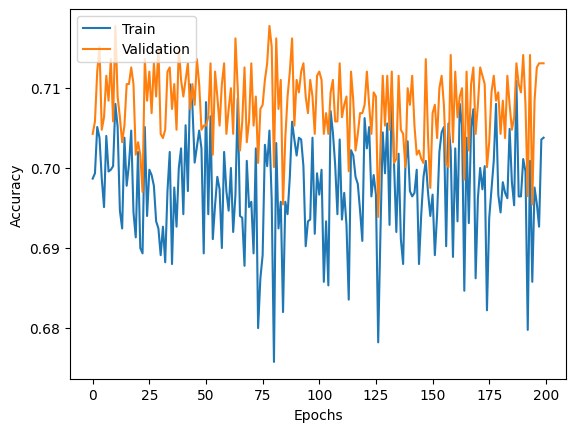

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Neural Network with Dropout

In [ ]:
number_of_input_features = 11  # Number of input features in the dataset

# Reduced number of hidden units to 5 and just using 1 hidden layer
number_of_hidden_units = 5  # Number of hidden units in the neural network
epochs = 1000  # Number of training epochs
learning_rate = 0.01  # Learning rate for the optimizer
batch_size = 32  # Number of samples in each training batch
dropout_probablity = 0.6  # Probability of dropping out a neuron in dropout layer

# Convert training and testing data to PyTorch tensors
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)
X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

# Create a training dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    Tanh(),  # Add Tanh activation function
    Dropout(dropout_probablity),  # Dropout layer to prevent overfitting
    Linear(number_of_hidden_units, 1),  # Another linear layer
    Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
validation_accuracy_list = []  # List to store validation accuracy

# Training loop
for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy: {train_accuracy}, validation_accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

epoch 0/1000 ---> train_accuracy: 0.6839643716812134, validation_accuracy: 0.702182948589325
epoch 1/1000 ---> train_accuracy: 0.7084632515907288, validation_accuracy: 0.7110186815261841
epoch 2/1000 ---> train_accuracy: 0.699999988079071, validation_accuracy: 0.7115384340286255
epoch 3/1000 ---> train_accuracy: 0.7062360644340515, validation_accuracy: 0.7084199786186218
epoch 4/1000 ---> train_accuracy: 0.7102450132369995, validation_accuracy: 0.7130976915359497
epoch 5/1000 ---> train_accuracy: 0.7089086771011353, validation_accuracy: 0.7141371965408325
epoch 6/1000 ---> train_accuracy: 0.705790638923645, validation_accuracy: 0.7136174440383911
epoch 7/1000 ---> train_accuracy: 0.7026726007461548, validation_accuracy: 0.7089397311210632
epoch 8/1000 ---> train_accuracy: 0.7046770453453064, validation_accuracy: 0.7104989886283875
epoch 9/1000 ---> train_accuracy: 0.7082405090332031, validation_accuracy: 0.7146569490432739
epoch 10/1000 ---> train_accuracy: 0.7100222706794739, validati

Text(0, 0.5, 'accuracy')

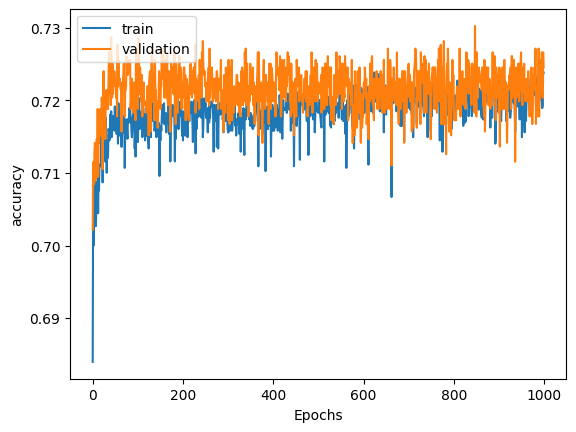

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('accuracy')

Neural Network with Early Stopping

In [32]:
# Importing necessary libraries
import torch as t
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Sequential, Linear, Tanh, Sigmoid
from torch.optim import Adam
from torch.nn import BCELoss
import matplotlib.pyplot as plt

# Defining the parameters
number_of_input_features = 11
number_of_hidden_units = 5
epochs = 1000
learning_rate = 0.01
batch_size = 32

# Loading and preprocessing the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creating a neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),
    Tanh(),
    Linear(number_of_hidden_units, 1),
    Sigmoid()
)

# Setting up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = BCELoss()

# Lists to store accuracy values during training
train_accuracy_list = []
validation_accuracy_list = []

# Main training loop
for epoch in range(epochs):
    # Learning rate scheduling (optional)
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        probs = model(X)

        # new loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y)

        per_epoch_loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with t.no_grad():
        # Calculate accuracy on train data
        model.eval()
        probs = model(X_train_tensor)
        prediction = (probs >= .5).type(t.LongTensor).view(-1)

        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs > .5).type(t.LongTensor).view(-1)

        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy : {train_accuracy} , validation_accuracy : {validation_accuracy}')
        model.train()
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

epoch 0/1000 ---> train_accuracy : 0.7055679559707642 , validation_accuracy : 0.7032224535942078
epoch 1/1000 ---> train_accuracy : 0.711581289768219 , validation_accuracy : 0.717255711555481
epoch 2/1000 ---> train_accuracy : 0.7044543623924255 , validation_accuracy : 0.7058212161064148
epoch 3/1000 ---> train_accuracy : 0.7055679559707642 , validation_accuracy : 0.7125779390335083
epoch 4/1000 ---> train_accuracy : 0.7091314196586609 , validation_accuracy : 0.7115384340286255
epoch 5/1000 ---> train_accuracy : 0.7189309597015381 , validation_accuracy : 0.7266111969947815
epoch 6/1000 ---> train_accuracy : 0.7178173661231995 , validation_accuracy : 0.7240124940872192
epoch 7/1000 ---> train_accuracy : 0.7184855341911316 , validation_accuracy : 0.7245322465896606
epoch 8/1000 ---> train_accuracy : 0.7171491980552673 , validation_accuracy : 0.7255717515945435
epoch 9/1000 ---> train_accuracy : 0.7155901789665222 , validation_accuracy : 0.7234927415847778
epoch 10/1000 ---> train_accurac

Text(0, 0.5, 'Accuracy')

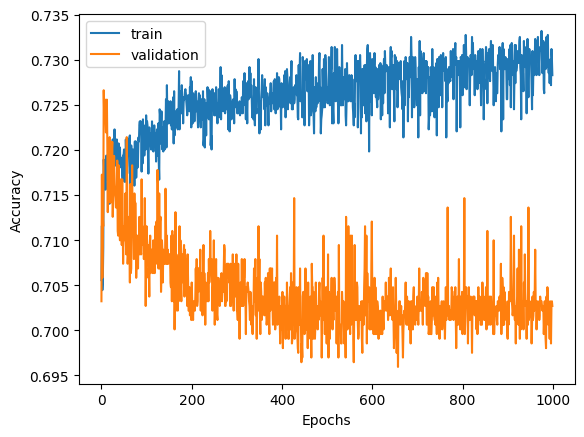

In [33]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')